## ディープニューラルネットワークスクラッチ

>前回は3層のニューラルネットワークを作成しましたが、今回はこれを任意の層数に拡張しやすいものに書き換えていきます。その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。
>
>このようなスクラッチを行うことで、今後各種フレームワークを利用していくにあたり、内部の動きが想像できることを目指します。
>
>名前は新しくScratchDeepNeuralNetworkClassifierクラスとしてください。

## 層などのクラス化  
>クラスにまとめて行くことで、構成を変更しやすい実装にしていきます。
>
>手を加える箇所
>
>- 層の数
>- 層の種類（今後畳み込み層など他のタイプの層が登場する）
>- 活性化関数の種類
>- 重みやバイアスの初期化方法
>- 最適化手法
>
>そのために、全結合層、各種活性化関数、重みやバイアスの初期化、最適化手法それぞれのクラスを作成します。
>
>実装方法は自由ですが、簡単な例を紹介します。サンプルコード1のように全結合層と活性化関数のインスタンスを作成し、サンプルコード2,3のようにして使用します。それぞれのクラスについてはこのあと解説します。

### 《サンプルコード1》  
>ScratchDeepNeuralNetworkClassifierのfitメソッド内

In [1]:
# self.sigma : ガウス分布の標準偏差
# self.lr : 学習率
# self.n_nodes1 : 1層目のノード数
# self.n_nodes2 : 2層目のノード数
# self.n_output : 出力層のノード数
#optimizer = SGD(self.lr)
#self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
#self.activation1 = Tanh()
#self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
#self.activation2 = Tanh()
#self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
#self.activation3 = Softmax()

### 《サンプルコード2》  
>イテレーションごとのフォワード

In [2]:
#A1 = self.FC1.forward(X)
#Z1 = self.activation1.forward(A1)
#A2 = self.FC2.forward(Z1)
#Z2 = self.activation2.forward(A2)
#A3 = self.FC3.forward(Z2)
#Z3 = self.activation3.forward(A3)

### 《サンプルコード3》  
>イテレーションごとのバックワード



In [3]:
#dA3 = self.activation3.backward(Z3, Y) # 交差エントロピー誤差とソフトマックスを合わせている
#dZ2 = self.FC3.backward(dA3)
#dA2 = self.activation2.backward(dZ2)
#dZ1 = self.FC2.backward(dA2)
#dA1 = self.activation1.backward(dZ1)
#dZ0 = self.FC1.backward(dA1) # dZ0は使用しない

## 【問題1】全結合層のクラス化  
>全結合層のクラス化を行なってください。
>
>以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。
>
>なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。
>
>また、引数として自身のインスタンス**`self`**を渡すこともできます。これを利用して**`self.optimizer.update(self)`**という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。
>
>初期化方法と最適化手法のクラスについては後述します。

In [5]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        #【問題１】
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
    
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        #【問題１】
        self.X = X
        A = self.X@self.W+self.B.reshape(-1,1).T
        
        return A
    
    
    def backward(self, dA, Z):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # 更新
        self, dZ = self.optimizer.update(self, dA, Z)
        
        return dZ

## 【問題2】初期化方法のクラス化  
>初期化を行うコードをクラス化してください。
>
>前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。
>
>これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。



In [6]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        #【問題2】
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        #【問題2】
        B = self.sigma * np.random.randn(n_nodes2,)
        
        return B

## 【問題3】最適化手法のクラス化  
>最適化手法のクラス化を行なってください。
>
>最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。
>
>これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [7]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer, dA, Z):#Z3, Y, 
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #dL_dA3 = Z3 - Y
        dB = np.sum(dA, axis=0)#バッチサイズ分の合計
        dW = Z.T@dA
        
        dZ = dA@layer.W.T
        
        #【問題3】
        layer.W = layer.W - self.lr*(dW)
        layer.B = layer.B - self.lr*(dB)
        
        return (layer, dZ)
        

## 【問題4】活性化関数のクラス化  
>活性化関数のクラス化を行なってください。
>
>ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。
### 発展的要素
>活性化関数や重みの初期値、最適化手法に関してこれまで見てきた以外のものを実装していきます

In [8]:
class Sigmoid():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = 1/(1+np.exp(-X))
        
        return Z
    
    def backward(self, X, dZ):
        """
        逆伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        sigmoid_A = 1/(1+np.exp(-X))
        dA = dZ*(1 - sigmoid_A)*sigmoid_A
        
        return dA
        

In [9]:
class Tanh():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = np.tanh(X)
        
        return Z
    

    def backward(self, X, dZ):
        """
        逆伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        dA = dZ*(1 - np.tanh(X)**2)
        
        return dA

In [10]:
class Softmax():
    """
    活性化関数（シグモイド関数）のクラス

    Attributes
    ----------
    """
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        Z = np.exp(X)/(np.sum(np.exp(X), axis=1).reshape(-1,1))
        
        return Z
    

    def backward(self, X, y):
        """
        逆伝播用
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        dA =X - y
        
        # 目的関数（損失関数）　交差エントロピー誤差
        nb = y.shape[0]#バッチサイズ
        L = -(1/nb)*(np.sum(y*np.log(X)))
        
        return (dA, L)

## 【問題5】ReLUクラスの作成  
>現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。
>
>ReLUは以下の数式です。
>
>$
f(x) = ReLU(x) = \begin{cases}
x  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$
>
>x : ある特徴量。スカラー
>
>実装上はnp.maximumを使い配列に対してまとめて計算が可能です。
>
>numpy.maximum — NumPy v1.15 Manual
>
>一方、バックプロパゲーションのための x に関する f(x) の微分は以下のようになります。
>
>$
\frac{\partial f(x)}{\partial x} = \begin{cases}
1  & \text{if $x>0$,}\\
0 & \text{if $x\leqq0$.}
\end{cases}
$
>
>数学的には微分可能ではないですが、 x=0 のとき 0 とすることで対応しています。
>
>フォワード時の x の正負により、勾配を逆伝播するかどうかが決まるということになります。



In [11]:
class ReLU:
    """
    活性化関数（ReLU）のクラス

    Attributes
    ----------
    """
    def __init__(self):
        pass
    
    def forward(self, X):
        """
        準伝播用

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        #Z = np.where(X <= 0, 0, X)
        Z = np.maximum(X, 0)
        
        return Z
    
    def backward(self, X, dZ):
        """
        逆伝播用
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        """
        # Xで判定して勾配を渡す
        dA = np.where(X <= 0, 0, dZ)
        
        return dA
    

## 【問題6】重みの初期値  
>ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。  
>しかし、どのような値にすると良いかが知られています。  
>シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。
>
>XavierInitializerクラスと、HeInitializerクラスを作成してください。

### Xavierの初期値  
>Xavierの初期値における標準偏差 σ は次の式で求められます。
>
>$
\sigma = \frac{1}{\sqrt{n}}
$
>
>n  : 前の層のノード数

In [12]:
class XavierInitializer:
    """
    ザビエル
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, n_nodes1):#シグマではなくノード数を入れる
        sigma = 1/np.sqrt(n_nodes1)
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2,)
        
        return B

### Heの初期値  
>Heの初期値における標準偏差 σ は次の式で求められます。
>
>$
\sigma = \sqrt{\frac{2}{n}}
$
>
>n  : 前の層のノード数

In [13]:
class HeInitializer:
    """
    フー
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, n_nodes1):#シグマではなくノード数を入れる
        sigma = np.sqrt(2/n_nodes1)
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2, )
        
        return B

## 【問題7】最適化手法  
>学習率は学習過程で変化させていく方法が一般的です。  
>基本的な手法である AdaGrad のクラスを作成してください。

>まず、これまで使ってきたSGDを確認します。
>
>$
W_i^{\prime} = W_i - \alpha E(\frac{\partial L}{\partial W_i}) \\
B_i^{\prime} = B_i - \alpha E(\frac{\partial L}{\partial B_i})
$
>
>α  : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）
>
>$
\frac{\partial L}{\partial W_i}  : W_iに関する損失 L の勾配
$
>
>$
\frac{\partial L}{\partial B_i}  : B_iに関する損失 L の勾配
$
>
>E()  : ミニバッチ方向にベクトルの平均を計算

>続いて、AdaGradです。バイアスの数式は省略しますが、重みと同様のことをします。
>
>更新された分だけその重みに対する学習率を徐々に下げていきます。イテレーションごとの勾配の二乗和 H を保存しておき、その分だけ学習率を小さくします。
>
>学習率は重み一つひとつに対して異なることになります。
>
>$
H_i^{\prime}  = H_i+E(\frac{\partial L}{\partial W_i})×E(\frac{\partial L}{\partial W_i})\\
W_i^{\prime} = W_i - \alpha \frac{1}{\sqrt{H_i^{\prime} }} E(\frac{\partial L}{\partial W_i}) \\
$
>
>Hi  : i層目に関して、前のイテレーションまでの勾配の二乗和（初期値は0）
>
>H′i : 更新した Hi

In [14]:
class AdaGrad:
    """
    最適化手法AdaGrad
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
    """
    def __init__(self, lr, n_nodes):
        self.lr = lr
        # RuntimeWarning: divide by zero encountered を避ける
        self.H = np.zeros(n_nodes)+1e-10
        
    def update(self, layer, dA, Z):
        #dL_dA3 = Z3 - Y
        dB = np.sum(dA, axis=0)#バッチサイズ分の合計
        dW = Z.T@dA
        
        dZ = dA@layer.W.T
        
        self.H = self.H + np.mean(dW, axis = 0)*np.mean(dW, axis = 0)
        
        layer.W = layer.W - self.lr*(1/np.sqrt(self.H))*np.mean(dW, axis = 0)
        layer.B = layer.B - self.lr*(1/np.sqrt(self.H))*np.mean(dW, axis = 0)
        
        return (layer, dZ)

## 【問題8】クラスの完成  
>任意の構成で学習と推定が行えるScratchDeepNeuralNetworkClassifierクラスを完成させてください。



#### ScratchDeepNeuralNetworkClassifier() クラス  
３層以上のレイヤーも扱えるようにするため、layer_informationという２次元配列に  
層ごとに「'最適化処理','活性化関数',入力ノード数,出力先ノード数,'初期化関数'」を入れて  
引数として渡すと、任意の階層の処理が行えるよう実装。

In [15]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    ディープニューラルネットワークのクラス
    Parameters
    ----------
    self.n_features 
    
    self.n_nodes1
    
    self.sigma
    
    """
    def __init__(self, lr, sigma = 0.01):
        self.lr = lr
        #self.n_features = n_features
        #self.n_nodes1 = n_nodes1
        #self.n_nodes2 = n_nodes2
        #self.n_output = n_output
        self.sigma = sigma
    
    def fit(self,X,y,layer_information, epoch=1, batch_size=20):

        # 各層のインスタンス、関数のインスタンス
        self.FC_list = []
        self.activation_list = []
        
        # レイヤー数を取得
        self.layer = len(layer_information)
        
        # 各層のインスタンス、関数のインスタンスを用意するためのループ
        for i in range(self.layer):
            n_nodes_a = layer_information[i][2]
            n_nodes_b = layer_information[i][3]
        
            #最適化関数の選択
            if layer_information[i][0] == 'AdaGrad':
                optimizer = AdaGrad(self.lr, n_nodes_b)
            else:
                optimizer = SGD(self.lr)

            #初期化の選択
            if layer_information[i][4] == 'XavierInitializer':
                FC_temp = FC(n_nodes_a, n_nodes_b, XavierInitializer(n_nodes_a), optimizer)
            elif layer_information[i][4] == 'HeInitializer':
                FC_temp = FC(n_nodes_a, n_nodes_b, HeInitializer(n_nodes_a), optimizer)
            else:
                FC_temp = FC(n_nodes_a, n_nodes_b, SimpleInitializer(self.sigma), optimizer)

            # 各層のインスタンスをリストで保管
            self.FC_list.append(FC_temp)
            
            #活性化関数の選択
            if layer_information[i][1]=='ReLU':
                activation_temp = ReLU()
            elif layer_information[i][1]=='Sigmoid':
                activation_temp = Sigmoid()
            elif layer_information[i][1]=='Softmax':
                # 最終層の関数
                activation_temp = Softmax()
            else:
                activation_temp = Tanh()

            # 各層の関数をリストで保管
            self.activation_list.append(activation_temp)
            
        # Loss Curv用のリスト
        L_list = []
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size)# ミニバッチ
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードのA、Zを保管するリスト
                A_list=[]
                Z_list=[]
                
                # 最初のZは　mini_X_train　なので代入
                Z = mini_X_train
                
                # フォワード処理
                for l in range(len(layer_information)):
                    A = self.FC_list[l].forward(Z)
                    Z = self.activation_list[l].forward(A)
                    A_list.append(A)
                    Z_list.append(Z)
                    
                #A1 = self.FC_list[0].forward(mini_X_train)
                #Z1 = self.activation_list[0].forward(A1)
                #A2 = self.FC_list[1].forward(Z1)
                #Z2 = self.activation_list[1].forward(A2)
                #A3 = self.FC_list[2].forward(Z2)
                #Z3 = self.activation_list[2].forward(A3)
                

                # バックワードの処理
                dA3, L = self.activation_list[-1].backward(Z_list[-1], mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC_list[-1].backward(dA3, Z_list[-2])#引数増やして渡す。Z2

                dZ = dZ2
                for l in reversed(range(1, len(layer_information)-1)):# 最初と最後をのぞいてループ
                    dA = self.activation_list[l].backward(A_list[l],dZ)#引数増やして渡す。A2
                    dZ = self.FC_list[l].backward(dA, Z_list[l-1])#引数増やして渡す。Z1
                
                # 値を引き渡すための変数
                dZ1 = dZ
                dA1 = self.activation_list[0].backward(A_list[0], dZ1)#引数増やして渡す。A1
                dZ0 = self.FC_list[0].backward(dA1, mini_X_train) # dZ0は使用しない #引数増やして渡す。X

                
                #dA3, L = self.activation_list[2].backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                #dZ2 = self.FC_list[2].backward(dA3, Z2)#引数増やして渡す。Z2
                #dA2 = self.activation_list[1].backward(A2,dZ2)#引数増やして渡す。A2
                #dZ1 = self.FC_list[1].backward(dA2, Z1)#引数増やして渡す。Z1
                #dA1 = self.activation_list[0].backward(A1, dZ1)#引数増やして渡す。A1
                #dZ0 = self.FC_list[0].backward(dA1, mini_X_train) # dZ0は使用しない #引数増やして渡す。X

            """
            Loss Curvを描くための処理
            """
            L_list.append(L)
            self.L_list = np.array(L_list) 
                
        
    def predict(self,X):

        # 最初のZはXなので代入
        Z = X

        # フォワード処理
        for l in range(self.layer):
            A = self.FC_list[l].forward(Z)
            Z = self.activation_list[l].forward(A)
            
        y = self.activation_list[-1].forward(A)
        pred = np.argmax(y, axis=1)
        
        #A1 = self.FC_list[0].forward(X)
        #Z1 = self.activation_list[0].forward(A1)
        #A2 = self.FC_list[1].forward(Z1)
        #Z2 = self.activation_list[1].forward(A2)
        #A3 = self.FC_list[2].forward(Z2)
        #y = self.activation_list[2].forward(A3)
        #pred = np.argmax(y, axis=1)
        
        return pred

## 【問題9】学習と推定  
>層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

## MNISTデータセット  

In [16]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [17]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [18]:
# 平準化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [19]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
print(y_train.shape)
print(y_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [23]:
# テスト用にデコード
y_test_decode = np.argmax(y_val, axis=1)
print(y_test_decode.shape)
print(y_test_decode)

(12000,)
[9 7 8 ... 9 1 0]


In [24]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

>pdf記載の良い組み合わせ 
>- Xavier と sigmoid/tanh
>- He と ReLU

任意のレイヤー数のDNN各層の情報を layer_information リストに入れて　fit 関数に引数として渡すと、  
自動的にレイヤーの数を計算して各層のインスタンスがされるよう作成。

In [102]:
# Tanh, Sigmoid, ReLU
# SGD, AdaGrad
# SimpleInitializer, XavierInitializer、HeInitializer

layer_information = [['SGD','ReLU',784,600,'HeInitializer'], # 第１層
                                   ['SGD','ReLU',600,400,'HeInitializer'], # 第2層
                                   ['SGD','ReLU',400,200,'HeInitializer'], # 第3層
                                   ['SGD','ReLU',200,100,'HeInitializer'], # 第4層
                                   ['AdaGrad','Softmax',100,10,'SimpleInitializer'], # 第5層
                                  ]

#### インスタンス化と学習

In [103]:
DNN = ScratchDeepNeuralNetrowkClassifier(lr=0.001, sigma=0.01)
DNN.fit(X_train, 
                y_train, 
                layer_information,
                epoch=100, 
                batch_size=20
               )

インスタンスが正しく作成されているか確認。

In [104]:
DNN.FC_list

In [105]:
DNN.activation_list

#### 推定とAccuracy

In [106]:
from sklearn.metrics import accuracy_score

In [107]:
y_pred = DNN.predict(X_val)
accuracy_score(y_test_decode, y_pred)

0.9781666666666666

In [108]:
DNN.L_list

array([0.37400654, 0.19222669, 0.13686016, 0.10845396, 0.08869528,
       0.0731665 , 0.06253138, 0.0548513 , 0.04845879, 0.04397902,
       0.03941795, 0.03684496, 0.03412166, 0.03307281, 0.03124972,
       0.02913789, 0.02808435, 0.02670658, 0.02497211, 0.02332544,
       0.02167598, 0.02015955, 0.01759825, 0.0160689 , 0.01468794,
       0.01338027, 0.0122737 , 0.01126884, 0.01068503, 0.0096104 ,
       0.00894641, 0.00808627, 0.00726337, 0.00676016, 0.00598637,
       0.00559843, 0.0050365 , 0.00467732, 0.00425011, 0.00398449,
       0.0036643 , 0.00338256, 0.00307555, 0.00294177, 0.00272793,
       0.00257284, 0.00239412, 0.00222274, 0.00210332, 0.00198736,
       0.00185763, 0.00175588, 0.00166887, 0.00157116, 0.00153598,
       0.00147096, 0.00141163, 0.00134696, 0.00130105, 0.00125447,
       0.00121429, 0.00117605, 0.00113976, 0.00111294, 0.00107865,
       0.0010454 , 0.00102808, 0.00100171, 0.00098216, 0.00095982,
       0.00093271, 0.00091369, 0.00089823, 0.00087912, 0.00085

#### 損失関数グラフ

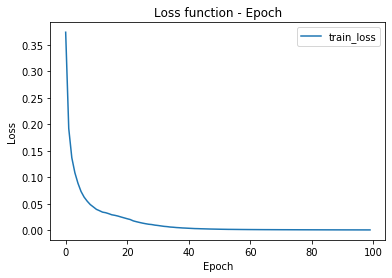

In [109]:
loss_function_epoch = DNN.L_list
#loss_function_epoch_val = DNN.L_list_val
plt.title('Loss function - Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_function_epoch, label='train_loss')#, color='b'
#plt.plot(loss_function_epoch_val, label='val_loss')# color='b'
plt.legend(loc='best')

活性化関数にReLU、初期化にHe、最適化関数にSGDを用いて、学習率0.001、エポック100の  
設定で実行したところ、精度が最も高くなった。  
ただし、上記設定では学習曲線の形が若干よくなかったため、最終層の最適化にAdaGradを用いたところ、  
精度は0.05％程度下がったが学習曲線がガタついたりせず綺麗な形になった。

以上